# Inference with COSDD

In this notebook, we will use the model trained in the previous step to denoise the data.

In [1]:
import os
import logging

import tifffile
import torch
import lightning as L
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import utils
from dvlae import DVLAE

logger = logging.getLogger('lightning.pytorch')
logger.setLevel(logging.WARNING)
%matplotlib inline

In [2]:
use_cuda = torch.cuda.is_available()

## 1. Load test data
The images that we want to denoise are loaded here.

In [3]:
# Go into the folder and stack all of the tiffs into one pytorch tensor
data_dir = "./data/Fluo-C3DH-A549/01"
files = os.listdir(data_dir)
images = [f for f in files if f.endswith(".tif")]
images.sort()
low_snr = [tifffile.imread(os.path.join(data_dir, f)) for f in images]
low_snr = np.stack(low_snr).astype(float)[:, np.newaxis]  # Add channel dimension
low_snr = torch.tensor(low_snr, dtype=torch.float32)

print(f"Noisy data size: {low_snr.size()}")

Noisy data size: torch.Size([30, 1, 29, 300, 350])


As with training, data should be a `torch.Tensor` with dimensions: [Number of images, Channels, Depth, Height, Width] with data type float32.

## 2. Create prediction dataloader

`predict_batch_size` (int) Number of denoised images to produce at a time.

In [4]:
predict_batch_size = 1

predict_set = utils.PredictDataset(low_snr)
predict_loader = torch.utils.data.DataLoader(
    predict_set,
    batch_size=predict_batch_size,
    shuffle=False,
    pin_memory=True,
)

## 3. Load trained model

Set the `model_name` to match the model name used in the training notebook.

In [5]:
model_name = "Fluo-C3DH-A549"
checkpoint_path = os.path.join("checkpoints", model_name)

dvlae = DVLAE.load_from_checkpoint(os.path.join(checkpoint_path, "final_model.ckpt"))

trainer = L.Trainer(
    accelerator="gpu" if use_cuda else "cpu",
    devices=1,
    enable_progress_bar=False,
    precision="bf16-mixed" if use_cuda else "fp32",
)

/home/ben/miniforge3/envs/autonoise/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'vae' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vae'])`.
/home/ben/miniforge3/envs/autonoise/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'ar_decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['ar_decoder'])`.
/home/ben/miniforge3/envs/autonoise/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 's_decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['s_decoder'])`.
/home/ben/miniforge3/envs/autonoise/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'direct_d

## 4. Denoise
In this section, we will look at how COSDD does inference. <br>

The model denoises images randomly, giving us a different output each time. First, we will compare two randomly sampled denoised images for the same noisy image. Then, we will produce a single consensus estimate by averaging 100 randomly sampled denoised images. Finally, if the direct denoiser was trained in the previous step, we will see how it can be used to estimate this average in a single pass.

### 4.1 Random sampling 
First, we will denoise each image seven times and look at the difference between each estimate. The output of the model is stored in the `samples` variable. This has dimensions [Number of images, Sample index, Channels, Depth, Height, Width] where different denoised samples for the same image are stored along sample index.

In [9]:
use_direct_denoiser = False
n_samples = 7

dvlae.direct_pred = use_direct_denoiser

samples = []
for _ in tqdm(range(n_samples)):
    out = trainer.predict(dvlae, predict_loader)
    out = torch.cat(out, dim=0)
    samples.append(out)

samples = torch.stack(samples, dim=1).half() # Convert tensors from bfloat16 to float16 for compatibility with other libraries

100%|██████████| 7/7 [00:41<00:00,  5.94s/it]


Viewing the results. Use `crop` to select the slice to view.

In [10]:
vmin = np.percentile(low_snr.numpy(), 1)
vmax = np.percentile(low_snr.numpy(), 99)

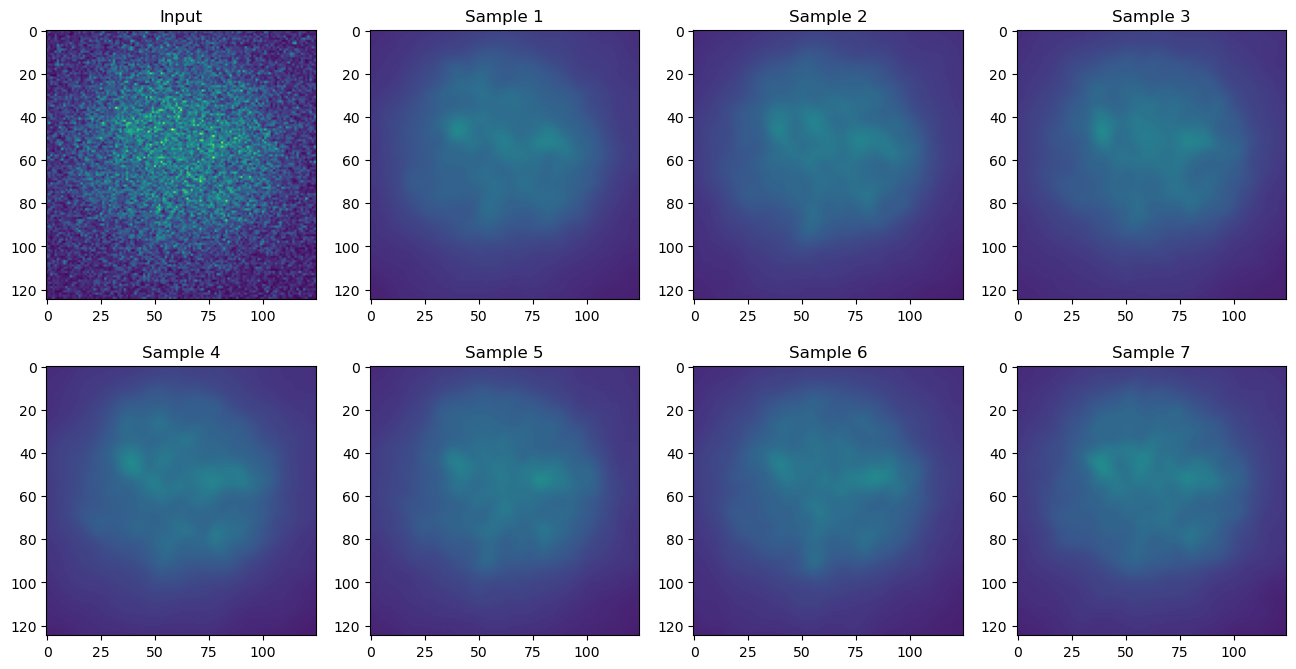

In [11]:
####### T   C  Z   Y                X #######
crop = (10, 0, 10, slice(100, 225), slice(100, 225))

fig, ax = plt.subplots(2, 4, figsize=(16, 8))
ax[0, 0].imshow(low_snr[crop], vmin=vmin, vmax=vmax)
ax[0, 0].set_title("Input")
for i in range(n_samples):
    ax[(i+1)//4, (i+1)%4].imshow(samples[crop[0]][i][crop[1:]], vmin=vmin, vmax=vmax)
    ax[(i+1)//4, (i+1)%4].set_title(f"Sample {i+1}")

plt.show()

The seven sampled denoised images have subtle differences that express the uncertainty involved in this denoising problem.

### 4.2 MMSE estimate

In the next cell, we sample 100 denoised images and average them for the minimum mean square estimate (MMSE). The averaged images will be stored in the `MMSEs` variable, which has the same dimensions as `low_snr`. Change `n_samples` to average a different number of images.

In [16]:
use_direct_denoiser = False
n_samples = 100

dvlae.direct_pred = use_direct_denoiser

samples = []
for _ in tqdm(range(n_samples)):
    out = trainer.predict(dvlae, predict_loader)
    out = torch.cat(out, dim=0)
    samples.append(out)

samples = torch.stack(samples, dim=1).half()  # Convert tensors from bfloat16 to float16 for compatibility with other libraries
MMSEs = torch.mean(samples, dim=1)

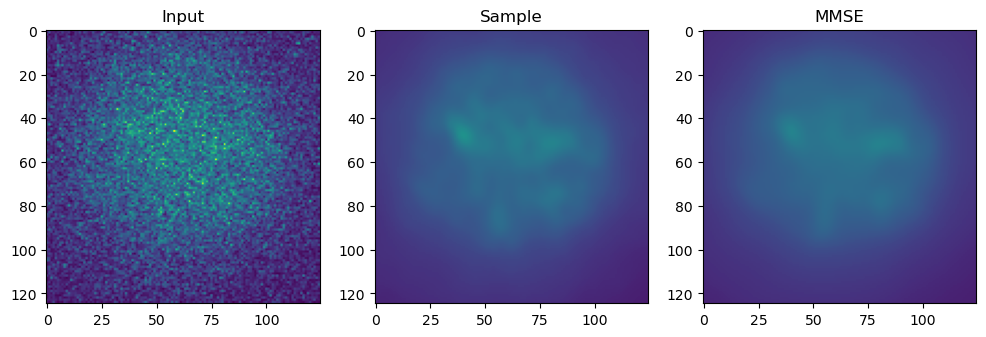

In [17]:
####### T   C  Z   Y                X #######
crop = (10, 0, 10, slice(100, 225), slice(100, 225))

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(low_snr[crop], vmin=vmin, vmax=vmax)
ax[0].set_title("Input")
ax[1].imshow(samples[crop[0]][0][crop[1:]], vmin=vmin, vmax=vmax)
ax[1].set_title("Sample")
ax[2].imshow(MMSEs[crop], vmin=vmin, vmax=vmax)
ax[2].set_title("MMSE")

plt.show()

The MMSE will usuallty be closer to the reference than an individual sample and would score a higher PSNR, although it will also be blurrier.

### 4.3 Direct denoising
Sampling 100 images and averaging them is a very time consuming. If the direct denoiser was trained in the previous notebook, it can be used to directly output what the average denoised image would be for a given noisy image.

In [18]:
use_direct_denoiser = True
dvlae.direct_pred = use_direct_denoiser

direct = trainer.predict(dvlae, predict_loader)
direct = torch.cat(direct, dim=0).half()  # Convert tensors from bfloat16 to float16 for compatibility with other libraries

/home/ben/miniforge3/envs/autonoise/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.


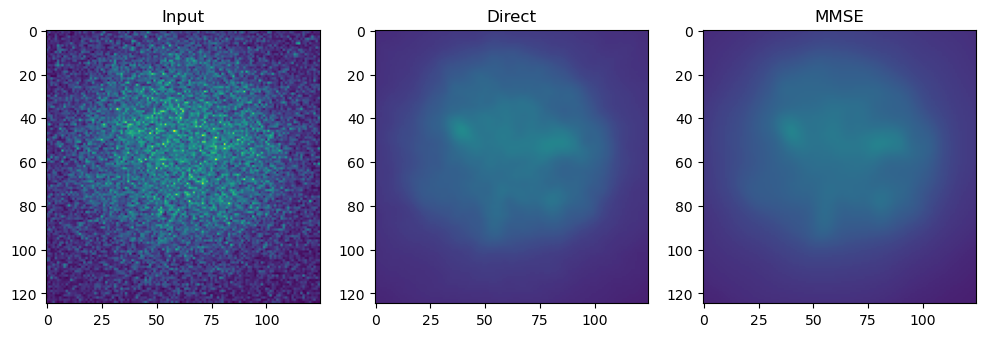

In [19]:
####### T   C  Z   Y                X #######
crop = (10, 0, 10, slice(100, 225), slice(100, 225))

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(low_snr[crop], vmin=vmin, vmax=vmax)
ax[0].set_title("Input")
ax[1].imshow(direct[crop], vmin=vmin, vmax=vmax)
ax[1].set_title("Direct")
ax[2].imshow(MMSEs[crop], vmin=vmin, vmax=vmax)
ax[2].set_title("MMSE")

plt.show()

The PSNR of the direct estimate is often higher than the PSNR of the average of 100 samples.